# py_mpc.ipynb

## Lecture 10 of CMU16-745 (2025)
Created: Mar 11, 25

No meshcat simulation.

In [1]:
!pip install osqp

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
#from numpy.linalg import solve
import scipy as sp
from scipy.sparse.linalg import  spsolve
from scipy.sparse import kron, block_diag, identity, hstack,vstack,lil_array,csc_array,dok_array
import osqp
import control as ctl

In [3]:
#Model parameters
g = 9.81 #m/s^2
m = 1.0 #kg 
l = 0.3 #meters
J = 0.2*m*l*l

#Thrust limits
umin = np.array([0.2*m*g, 0.2*m*g]).reshape(2,1)
umax = np.array([0.6*m*g, 0.6*m*g]).reshape(2,1)

h = 0.05 #time step (20 Hz)

In [4]:
#Planar Quadrotor Dynamics
def quad_dynamics(x,u):
    theta = x[2]

    xdd = ((1/m)*(u[0] + u[1])*np.sin(theta))
    #print(xdd)
    ydd = ((1/m)*(u[0] + u[1])*np.cos(theta) - g)
    #print(ydd)
    thetadd = ((1/J)*(l/2)*(u[1] - u[0]))
    #print(thetadd)
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    #x_result = np.array([x3,x4,x5, xdd, ydd, thetadd]).reshape(6,1)
    x_result = [x3,x4,x5,xdd,ydd,thetadd]
    
    return x_result

In [5]:
#  original. Does not work!
# def quad_dynamics_rk4(x,u):
#     #RK4 integration with zero-order hold on u
#     f1 = quad_dynamics(x, u)
#     f2 = quad_dynamics(x + 0.5*h*np.array(f1).reshape(6,1), u)
#     f3 = quad_dynamics(x + 0.5*h*np.array(f2).reshape(6,1), u)
#     f4 = quad_dynamics(x + h*np.array(f3).reshape(6,1), u)
#     return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)

In [5]:
#   ------- modified ------------
def quad_dynamics_rk4(x,u):
    #RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    # print("============ x ============")
    # print(x)
    # print(x.shape)
    # print("=========== f1 ==========")
    # print(f1)

    f1a = [0.5*h*i for i in f1] # must do this for it to work

    # print("========== x+ f1a ==========")
    # print(x + f1a)

    f2 = quad_dynamics(x + f1a, u)
    # print("=========== f2 ==========")    
    # print(f2)
    f2a = [0.5*h*i for i in f2] # must do this for it to work
    f3 = quad_dynamics(x + f2a, u)
    # print("=========== f3 ==========")    
    # print(f3)    
    f3a = [0.5*h*i for i in f3] # must do this for it to work
    
    f4 = quad_dynamics(x + f3a, u)
    # print("=========== f4 ==========")    
    # print(f4)

    ft = f1a
    for i in range(len(ft)):
        ft[i] = x[i] + (h/6.0)*(f1[i] + 2*f2[i] + 2*f3[i] + f4[i])

    return ft

In [6]:
# wrapper to make PyDrake forwarddiff works
def quad_dynamics_rk4_x(x):
    global u_hover 
    return quad_dynamics_rk4(x, u_hover.flatten())

def quad_dynamics_rk4_u(u):
    global x_hover 
    return quad_dynamics_rk4(x_hover.flatten(), u)    
    

In [8]:
#Linearized dynamics for hovering
x_hover = np.zeros((6,1))
u_hover = np.array([[0.5*m*g],[ 0.5*m*g]])

In [9]:
u_hover

array([[4.905],
       [4.905]])

In [10]:
from pydrake import forwarddiff

In [11]:
A = forwarddiff.jacobian(quad_dynamics_rk4_x,x_hover.flatten())
A

array([[1.0000000e+00, 0.0000000e+00, 1.0218750e-02, 5.0000000e-02,
        0.0000000e+00, 1.5328125e-04],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        5.0000000e-02, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 5.0000000e-02],
       [0.0000000e+00, 0.0000000e+00, 4.9050000e-01, 1.0000000e+00,
        0.0000000e+00, 1.0218750e-02],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00]])

In [12]:
B = forwarddiff.jacobian(quad_dynamics_rk4_u,u_hover.flatten())
B

array([[-1.06445313e-05,  1.06445313e-05],
       [ 1.04166667e-03,  1.04166667e-03],
       [-8.68055556e-03,  8.68055556e-03],
       [-1.27734375e-03,  1.27734375e-03],
       [ 5.00000000e-02,  5.00000000e-02],
       [-4.16666667e-01,  4.16666667e-01]])

In [13]:
quad_dynamics_rk4(x_hover,u_hover)

[array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]

In [14]:
Nx = 6     # number of state
Nu = 2     # number of controls
Tfinal = 10.0 # final time #try larger values
Nt = int(Tfinal/h)+1    # number of time steps
thist = np.arange(0,h*(Nt-1),h)

In [15]:
# Cost weights
Q = 1.0*np.eye(Nx)
R = 0.01*np.eye(Nu)
Qn = 1.0*np.eye(Nx)

In [16]:
def Cost(xhist, uhist):
    xend = xhist[:,-1]
    cost = 0.5*xend.T@Qn@xend
    for k in range(xhist.shape[1]-1):
        xk = xhist[:,k]
        uk = uhist[0,k]
        cost = cost + 0.5*xk.T@Q@xk + 0.5*uk*R*uk
    return cost

In [17]:
#LQR Hover Controller
P,_,_ = ctl.dare(A,B,Q,R)
K,_,_ = ctl.dlqr(A,B,Q,R)

def lqr_controller(t,x):
    global K, x_ref
    return u_hover - K@(x-x_ref)

In [140]:
K

array([[-1.01961303,  4.88080709, -6.425885  , -1.5454789 ,  5.3779013 ,
        -1.351607  ],
       [ 1.01961303,  4.88080709,  6.425885  ,  1.5454789 ,  5.3779013 ,
         1.351607  ]])

In [246]:
P

array([[3.03150087e+01, 4.09182373e-14, 2.39223482e+01, 1.22171187e+01,
        2.81294349e-15, 6.40307274e-01],
       [4.09182373e-14, 2.20369345e+01, 9.58915591e-14, 3.89101223e-14,
        1.58973867e+00, 2.22735315e-15],
       [2.39223482e+01, 9.58915591e-14, 1.31430548e+02, 3.48838584e+01,
        3.06534492e-14, 3.71339865e+00],
       [1.22171187e+01, 3.89101223e-14, 3.48838584e+01, 1.61398694e+01,
        6.44475616e-15, 9.48528786e-01],
       [2.81294349e-15, 1.58973867e+00, 3.06534492e-14, 6.44475616e-15,
        2.12194764e+00, 8.74507094e-16],
       [6.40307274e-01, 2.22735315e-15, 3.71339865e+00, 9.48528786e-01,
        8.74507094e-16, 1.13408104e+00]])

In [ ]:
# Build QP matrices for OSQP
Nh = 20 # one second horizon at 20 Hz
#Nx = 6  # Nx, Nu defined above
#Nu = 2
U = kron(identity(Nh),hstack((identity(Nu),lil_array(np.zeros((Nu,Nx)))))) # matrix that picks out all u
#U = csc_array(U)
T = kron(identity(Nh),np.array([0,0,0,0,1,0,0,0])) # matrix that picsks out all x3 (theta)
#T = csc_array(T)
H_12 = vstack((hstack((R,lil_array(np.zeros((Nu,Nx))))),
        hstack((lil_array(np.zeros((Nx,Nu))),Q))))
H_11 = kron(identity(Nh-1),H_12)
H_13 = lil_array(np.zeros(((Nx+Nu)*(Nh-1),Nx+Nu)))
H_1 = hstack((H_11,H_13))

# H_1 = hstack((kron(identity(Nh-1), vstack((hstack((R,lil_array(np.zeros((Nu,Nx))))),
#         hstack((lil_array(np.zeros((Nx,Nu))),Q)))))
#               ,lil_array(np.zeros(((Nx+Nu)*(Nh-1),Nx+Nu)))))
H_3 = lil_array(np.zeros((Nx+Nu,(Nx+Nu)*(Nh-1))))
H_4 = vstack((hstack((R,lil_array((np.zeros((Nu,Nx)))))),hstack((lil_array(np.zeros((Nx,Nu))),P))))
H_2 = hstack((H_3,H_4))
H = vstack((H_1,H_2))
#H = csc_array(H)

b = np.zeros((Nh*(Nx+Nu),1))

C_1 = hstack((B, -identity(Nx), lil_array(np.zeros((Nx,(Nh-1)*(Nu+Nx))))))
C_5 = hstack((kron(identity(Nh-1),hstack((lil_array(A),lil_array(B)))), lil_array(np.zeros(((Nh-1)*Nx,Nx)))))

C_6 = hstack((lil_array(np.zeros(((Nh-1)*Nx,Nx))), 
              kron(identity(Nh-1),hstack((lil_array(np.zeros((Nx,Nu))),-identity(Nx))))))
C_4 = hstack((lil_array(np.zeros((Nx*(Nh-1),Nu))),C_5+C_6))
C = vstack((C_1,C_4))
#C = csc_array(C)

# Dynamics + Thrust limit constraints
D = vstack((C,U))
lb = vstack((lil_array(np.zeros((Nx*Nh,1))),kron(lil_array(np.ones((Nh,1))),umin - u_hover)))
ub = vstack((lil_array(np.zeros((Nx*Nh,1))),kron(lil_array(np.ones((Nh,1))),umax - u_hover)))              

#Dynamics + thrust limit + bound constraint on θ to keep the system within small-angle approximation
# D = vstack((C,U,T))
# lb = vstack((lil_array(np.zeros((Nx*Nh,1))),
#              kron(lil_array(np.ones((Nh,1))),umin - u_hover),-0.2*lil_array(np.ones((Nh,1)))))
# ub = vstack((lil_array(np.zeros((Nx*Nh,1))),
#              kron(lil_array(np.ones((Nh,1))),umax - u_hover),0.2*lil_array(np.ones((Nh,1)))))     

lb = dok_array(lb)
ub = dok_array(ub)
prob = osqp.OSQP()
prob.setup(P=H,q=b,A=D,l=lb.toarray(),u=ub.toarray(),verbose=False,eps_abs=1e-8,eps_rel=1e-8,polish=1)


/opt/conda/lib/python3.12/site-packages/osqp/utils.py:118: UserWarning: Converting sparse P to a CSC (compressed sparse column) matrix. (It may take a while...)
  warn("Converting sparse P to a CSC " +
/opt/conda/lib/python3.12/site-packages/osqp/utils.py:122: UserWarning: Converting sparse A to a CSC (compressed sparse column) matrix. (It may take a while...)
  warn("Converting sparse A to a CSC " +


In [19]:
# MPC Controller
def mpc_controller(t,x):
    global x_ref, lb, ub, b
    # Update QP problem
    lb[0:6,[0]] = -A@x
    ub[0:6,[0]] = -A@x
    # print("lb[0:6,[0]] = ")
    # print(lb[0:6,[0]])
    # print("ub[0:6,[0]]")
    # print(ub[0:6,[0]])
    for j in range(Nh-1):
        idx = Nu+j*(Nx+Nu)
        b[idx:Nx+idx,[0]] = -Q@x_ref
    idx = Nu+(Nh-1)*(Nx+Nu)
    b[idx:Nx+idx,[0]] = -P@x_ref
    # print("b = ")
    # print(b)
    # print("b shape = ")
    # print(b.shape)
    prob.update(q=b, l=lb.toarray(), u=ub.toarray())
    results = prob.solve()
    # print(results.x)
    du = results.x[0:Nu].reshape(2,1)
    return u_hover + du
    
    



In [20]:
def closed_loop(x0, controller, N):
    xhist = np.zeros((len(x0),N))
    u0 = controller(0,x0)
    uhist = np.zeros((len(u0),N-1))
    uhist[:,[0]] = u0
    xhist[:,[0]] = x0
    for k in range(N-1):
        uk = controller(k,xhist[:,[k]])
        uhist[:,[k]] = np.maximum(np.minimum(umax, uk), umin) # enforce control limits
        xhist[:,[k+1]] = quad_dynamics_rk4(xhist[:,[k]], uhist[:,[k]])
    return xhist, uhist

In [29]:
x_ref = np.array([0.0,1.0,0.,0.,0.,0.]).reshape(6,1)
x0 = np.array([10.,2.,0.,0.,0.,0.]).reshape(6,1)
xhist1, uhist1 = closed_loop(x0,lqr_controller, Nt)
xhist2, uhist2 = closed_loop(x0, mpc_controller, Nt)

In [23]:
# comparison plot
def compare(t,v1, v2, label):
    plt.figure()
    plt.plot(t,v1,"m-",t,v2,"g-")
    plt.xlabel("time (sec)")
    plt.ylabel(label)
    plt.legend([label+" LQR",label+" MPC"])
    plt.grid(True)
    plt.show()   

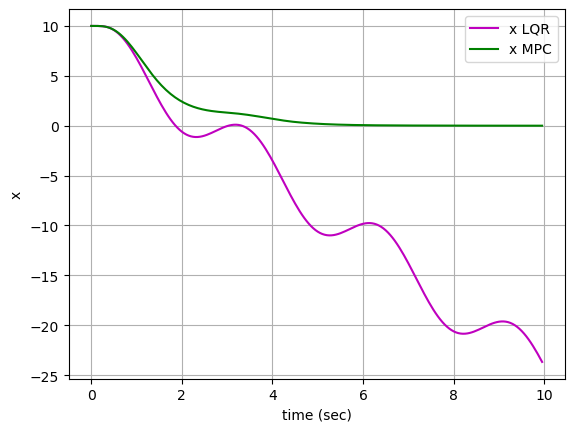

In [30]:
compare(thist,xhist1[0,:-1],xhist2[0,:-1],"x")

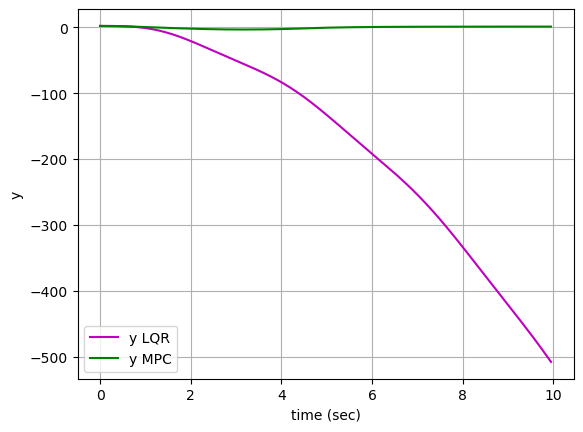

In [31]:
compare(thist,xhist1[1,:-1],xhist2[1,:-1],"y")

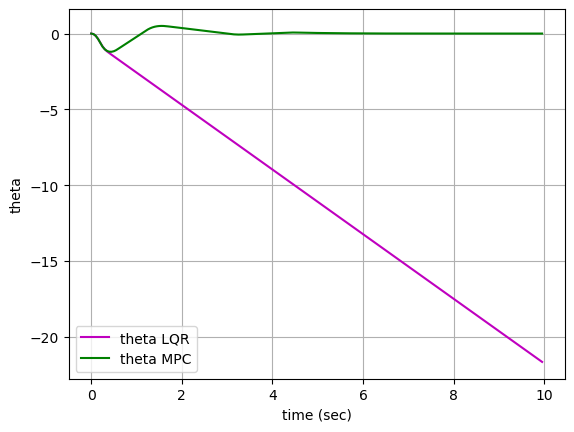

In [32]:
compare(thist,xhist1[2,:-1],xhist2[2,:-1],"theta")

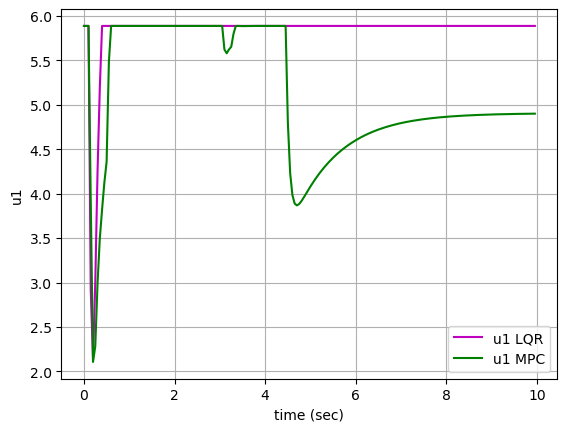

In [33]:
compare(thist,uhist1[0,:],uhist2[0,:],"u1")

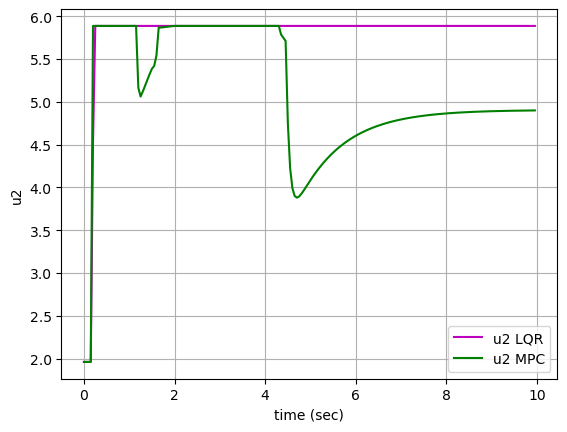

In [34]:
compare(thist,uhist1[1,:],uhist2[1,:],"u2")